In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [59]:
import seaborn as sns
sns.set()

In [60]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [61]:
#Data saved in csv/excel
import glob, os

data_dir= '/content/gdrive/My Drive/QB/'
os.chdir(data_dir)

In [62]:
!ls

2.extracurr-activity-sample_2020.xlsx  task2.gsheet  Task2_slides.gslides
task2.csv			       task2.ipynb


In [63]:
df= pd.read_excel("2.extracurr-activity-sample_2020.xlsx", sheet_name='raw-data')

In [64]:
cate= pd.read_excel("2.extracurr-activity-sample_2020.xlsx", sheet_name='categories')
cate.shape

(15, 1)

In [65]:
cate

,Categories
0,Academic
1,Art
2,Athletics
3,Career-Oriented
4,Community Service (Volunteer)
5,Cultural
6,Debate/Speech
7,Environmental
8,Family Responsibilities
9,Foreign Exchange


In [66]:
df.shape

(2000, 8)

In [67]:
df.Category.value_counts()

Other                             892
Other:In School Activities        661
Other:Out of School Activities    337
Other Music:Group                 109
Name: Category, dtype: int64

In [68]:
del df['Main Category _Corrected']

In [69]:
#There are 3 students dont have a Description for their extracurr-activity and they have to be taken out from the text classification
df[df['Description'].isnull()]

,Student ID,Year,Gender,PositionHonor,Description,Main Category,Category
1108,1109,2015,F,an organization create called Planeta Junes Ku...,NaN,Other Activity/Club,Other:Out of School Activities
1395,1396,2014,F,NaN,NaN,Other Activity/Club,Other:In School Activities
1536,1537,2014,F,NaN,NaN,Other Activity/Club,Other:In School Activities


In [14]:
target = "Description"

In [71]:
df[target]=df[target].str.lower()

In [72]:
data =df[df[target].notnull()]

In [74]:
df.head()

,Student ID,Year,Gender,PositionHonor,Description,Main Category,Category
0,1,2020,F,2nd place districts story-teller,forensics/speech,Other Activity/Club,Other
1,2,2020,F,Collaboration w/ Kaohsiung Organizing Committe...,world games newspaper committee (wgnc),Other Activity/Club,Other:In School Activities
2,3,2020,F,We organize Sports Day and many other in- and ...,athletic council,Other Activity/Club,Other:In School Activities
3,4,2020,M,I found an elementary school to tutor kids alo...,"interact club,a volunteering club.",Other Activity/Club,Other:In School Activities
4,5,2020,M,NaN,2009 flint debutante,Other Activity/Club,Other:Out of School Activities


In [17]:
data.shape

(1997, 7)

## Extracting Keywords

In [75]:
import nltk
nltk.download('stopwords')

stopwords = nltk.corpus.stopwords.words('english')
newStopWords = ['team','club','program']
stopwords.extend(newStopWords)

tfidf = TfidfVectorizer(
    min_df = 5,
    max_df = 0.95,
    max_features = 8000,
    stop_words = newStopWords
)
tfidf.fit(data[target])
text = tfidf.transform(data[target])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Fit 6 clusters
Fit 7 clusters
Fit 8 clusters
Fit 9 clusters
Fit 10 clusters
Fit 11 clusters
Fit 12 clusters
Fit 13 clusters
Fit 14 clusters
Fit 15 clusters
Fit 16 clusters
Fit 17 clusters
Fit 18 clusters
Fit 19 clusters
Fit 20 clusters


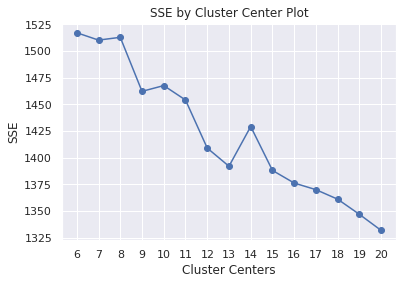

In [76]:
def find_optimal_clusters(data, max_k):
    iters = range(6, max_k+1)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(text, 20)

## From the graph above, I determine the number of clusters I would like to keep. The approach consists of looking for a kink or elbow in the WCSS graph. Usually, the part of the graph before the elbow would be steeply declining, while the part after it – much smoother. In this instance, the kink comes at the 13 clusters mark. So, we’ll be keeping a 13-cluster solution.

In [77]:
clusters = MiniBatchKMeans(n_clusters=13, init_size=1024, batch_size=2048, random_state=20).fit_predict(text)

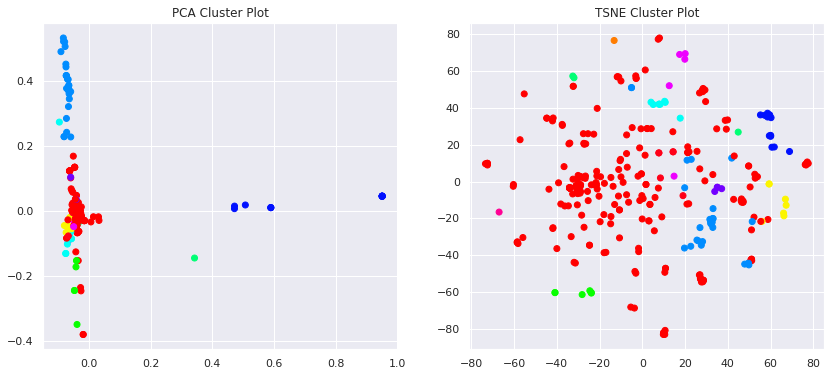

In [78]:
def plot_tsne_pca(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=3000)
    
    # reduce the features to 2D
    pca = PCA(n_components=2).fit_transform(data[max_items,:].todense())
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data[max_items,:].todense()))
    
    
    idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]

    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')

    
plot_tsne_pca(text,clusters)

In [102]:
def create_newdf(df,col, X, true_k):
	model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10)
	model.fit(X)
	labels=model.labels_
	newdf=pd.DataFrame(list(zip(df['Student ID'], df[col],labels)), columns =['Student ID', col, 'Cluster'])
 
	print(newdf.sort_values(by=['Cluster']))
	return newdf

In [103]:
newdf = create_newdf(data, target, clusters.reshape(-1, 1), 13)

      Student ID             Description  Cluster
1996        2000        fiction fanatics        0
1016        1017               forensics        0
1015        1016  anti defamation league        0
1014        1015   gay-straight alliance        0
1013        1014          mu alpha theta        0
...          ...                     ...      ...
1104        1105         philosophy club       12
608          609         philosophy club       12
942          943         philosophy club       12
1576        1580         philosophy club       12
384          385         philosophy club       12

[1997 rows x 3 columns]


# Use the target column to classify

In [104]:
from wordcloud import WordCloud
def wordcloud(newdf, col, true_k):
	for k in range(0,true_k):
	   s=newdf[newdf['Cluster']==k]
	   text=s[col].str.cat(sep=' ')
	   text=' '.join([word for word in text.split()])
	   wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
	   print('Cluster: {}'.format(k))
	   print(target)
	   titles=newdf[newdf['Cluster']==k][target][:10]         
	   print(titles.to_string(index=False))
	   plt.figure()
	   plt.imshow(wordcloud, interpolation="bilinear")
	   plt.axis("off")
	   plt.show()

Cluster: 0
Description
         interact club,a volunteering club.
                       2009 flint debutante
                            recording music
                 venture crew (outing club)
 music department extracurricular treasurer
                       feeding the homeless
                                 anime club
  personal blog & founding online community
                  aviation/aeronautics club
                      creative writing club


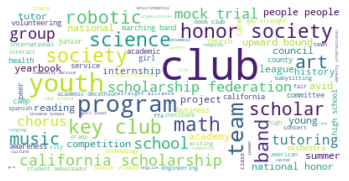

Cluster: 1
Description
                           concert choir
                   varsity concert choir
                        choir/show choir
                     genesis bells choir
                                   choir
                       lead choir singer
            concert choir, chamber choir
                                   choir
 jubilate- jensen beach auditioned choir
                                   choir


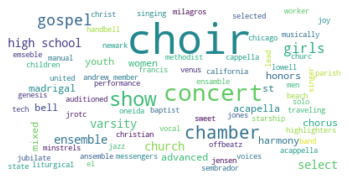

Cluster: 2
Description
  forensics/speech
            speech
 speech and debate
            speech
      debate squad
            speech
 speech and debate
            speech
  speech and drama
            debate


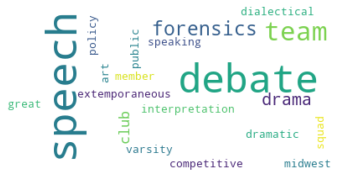

Cluster: 3
Description
          chess club
 thornton chess team
               chess
          chess club
          chess team
          chess club
          chess club
               chess
               chess
          chess club


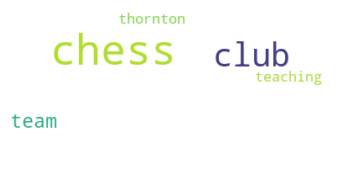

Cluster: 4
Description
                              athletic council
                            student ambassador
     california association of student council
                         top ten honor student
                 progressive student awareness
               student anti genocide coalition
 youth congress/student advisory council (sac)
             scholarship exchange student/host
           student reporter for local magazine
      stand, a student anti-genocide coalition


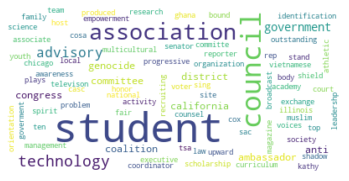

Cluster: 5
Description
 volunteer office assistant in family practice
      volunteer at children's hospital oakland
            volunteer elementary teacher's aid
               houston humane societ volunteer
              church volunteer missionary work
             volunteer work for cancer patient
                                     volunteer
                 volunteer at swedish hospital
           volunteer work at regional hospital
                volunteer work at nursing home


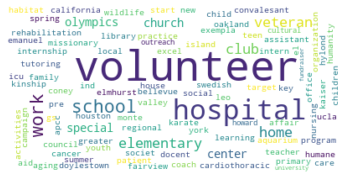

Cluster: 6
Description
                    future farmers of america
 substituting as head of household since 2007
    taking care of my grandmother (2002-2005)
      health occupational students of america
 family career and community leaders of amer.
                             top 10% of class
             taking care of my little brother
          3rd chair of dallas' all-city band.
            academy of information technology
        texas assiciation of future educators


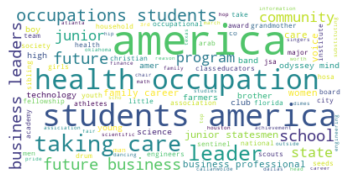

Cluster: 7
Description
               cps college bridge program
                saint louis college bound
                              college now
                              college now
                          college classes
                community college student
                            college match
 college now program (expository writing)
  enrolled in rio hondo community college
                           college bridge


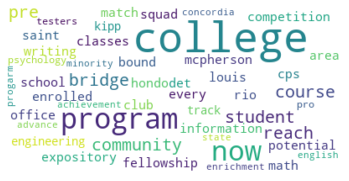

Cluster: 8
Description
 middle college national leadership conference
            county of alameda youth leadership
         nhi ylc (youth leadership conference)
  key club; build leadership by helping others
               central gwinnet leadership team
               the future leadership institute
                        leadership conferences
                   worship leadership training
 embracing latina leadership alliances nonprof
             leadership class in middle school


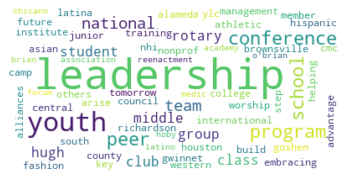

Cluster: 9
Description
      world games newspaper committee (wgnc)
                            school newspaper
                                   newspaper
             marshall flyer herald newspaper
               the lowell (school newspaper)
                                   newspaper
                            school newspaper
 ans advocate is the online school newspaper
                                   newspaper
                 writer for school newspaper


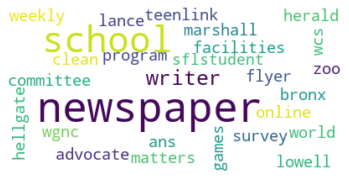

Cluster: 10
Description
              beta club
              beta club
              beta club
     national beta club
 zeta phi beta sorority
              beta club
              beta club
              beta club
              beta club
              beta club


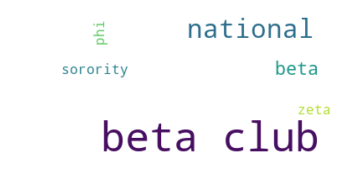

Cluster: 11
Description
                       hip hop dance team
                               folk dance
    dance club (ballroom and latin dance)
 intramural traditional dance competition
             show choir dance and singing
                project move (dance club)
                                    dance
                               dance team
                              break dance
              attend premier dance studio


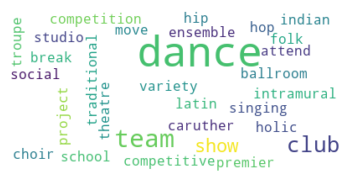

Cluster: 12
Description
        philosophy club
        philosophy club
 ithink philosophy club
        philosophy club
        philosophy club
        philosophy club
        philosophy club
        philosophy club
        philosophy club
        philosophy club


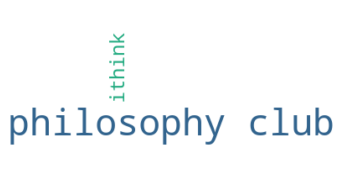

In [105]:
wordcloud(newdf, target, 13)

In [ ]:
cate

,Categories
0,Academic
1,Art
2,Athletics
3,Career-Oriented
4,Community Service (Volunteer)
5,Cultural
6,Debate/Speech
7,Environmental
8,Family Responsibilities
9,Foreign Exchange


From the wordCloud, I get to identify most of the clusters' categories. But I am not sure about Cluster 0 and 6, so I will classify them as others for now and may need manual labelling those in the future.

In [83]:
new_cate ={}

In [108]:
new_cate[6]='Other Activity/Club'
new_cate[0]='Other Activity/Club'

#philosophy
new_cate[12]='Academic'
#dance
new_cate[11]='Athletics'
#Chess
new_cate[3]='Athletics'
#beta club
new_cate[10]='Academic'
new_cate[4]='Student Government/Politics'
#Choir
new_cate[1]='Art'
new_cate[9]='Journalism/Publication'

#Leadership
new_cate[8]='Career-Oriented'
new_cate[5]='Community Service (Volunteer)'
new_cate[2]='Debate/Speech'
new_cate[7]='Academic'

In [109]:
newdf['Main Category _Corrected'] =newdf['Cluster'].replace(new_cate)


In [110]:
newdf.head()

,Student ID,Description,Cluster,Main Category _Corrected
0,1,forensics/speech,2,Debate/Speech
1,2,world games newspaper committee (wgnc),9,Journalism/Publication
2,3,athletic council,4,Student Government/Politics
3,4,"interact club,a volunteering club.",0,Other Activity/Club
4,5,2009 flint debutante,0,Other Activity/Club


## Classify some categories

In [112]:
index =newdf[newdf.Description.str.contains('music|art|band')].index
newdf.loc[index,'Main Category _Corrected'] = 'Art'

In [126]:
index =newdf[newdf.Description.str.contains('volunteer|key club|homeless')].index
newdf.loc[index,'Main Category _Corrected'] = 'Community Service (Volunteer)'

In [115]:
index =newdf[newdf.Description.str.contains('athletic|sports')].index
newdf.loc[index,'Main Category _Corrected'] = 'Athletics'

In [128]:
index =newdf[newdf.Description.str.contains('taking care')].index
newdf.loc[index,'Main Category _Corrected'] = 'Family Responsibilities'

In [129]:
index =newdf[newdf.Description.str.contains('church')].index
newdf.loc[index,'Main Category _Corrected'] = 'Religious'

In [130]:
index =newdf[newdf.Description.str.contains('environmental')].index
newdf.loc[index,'Main Category _Corrected'] = 'Environmental'

In [141]:
index =newdf[newdf.Description.str.contains('cultural|culture')].index
newdf.loc[index,'Main Category _Corrected'] = 'Cultural'

In [142]:
newdf['Main Category _Corrected'].value_counts()

Other Activity/Club              1410
Art                               172
Community Service (Volunteer)      97
Academic                           65
Student Government/Politics        60
Debate/Speech                      42
Athletics                          38
Career-Oriented                    34
Cultural                           26
Journalism/Publication             21
Religious                          15
Environmental                       9
Family Responsibilities             8
Name: Main Category _Corrected, dtype: int64

## Evaluation with unlabelled dataset

In [93]:
cls = MiniBatchKMeans(n_clusters=13, init_size=1024, batch_size=2048, random_state=20)
cls.fit(text)

MiniBatchKMeans(batch_size=2048, compute_labels=True, init='k-means++',
                init_size=1024, max_iter=100, max_no_improvement=10,
                n_clusters=13, n_init=3, random_state=20,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

In [94]:
from sklearn.metrics import silhouette_score
silhouette_score(text, labels=cls.predict(text))

0.15004349680765172

## Update the labels

In [143]:
result = pd.merge(df, newdf[['Student ID','Main Category _Corrected']], how='left', on=['Student ID'])

In [144]:
result.tail()

,Student ID,Year,Gender,PositionHonor,Description,Main Category,Category,Main Category _Corrected
1995,1996,2014,F,NaN,russian club: dancing cultures,Other Activity/Club,Other,Cultural
1996,1997,2014,M,NaN,buddy reading,Other Activity/Club,Other:In School Activities,Other Activity/Club
1997,1998,2014,M,The club educated the school comunity about th...,students against destructive decisions,Other Activity/Club,Other:In School Activities,Other Activity/Club
1998,1999,2014,M,NaN,math engineering science achievement (mesa),Other Activity/Club,Other:In School Activities,Other Activity/Club
1999,2000,2014,F,book club,fiction fanatics,Other Activity/Club,Other,Other Activity/Club


I realzied there are 109 rows are listed as Other Music:Group in Category column. Those rows can be assigned to Art since music is Art. And I can skip those rows for text classification.

In [145]:
index = result[result.Category=='Other Music:Group'].index

# now use df.loc to set values only to those rows
result.loc[index,'Main Category _Corrected'] = 'Art'

In [146]:
result['Main Category _Corrected'].value_counts()

Other Activity/Club              1364
Art                               225
Community Service (Volunteer)      97
Academic                           65
Student Government/Politics        59
Debate/Speech                      42
Athletics                          38
Career-Oriented                    33
Cultural                           26
Journalism/Publication             21
Religious                          10
Environmental                       9
Family Responsibilities             8
Name: Main Category _Corrected, dtype: int64

In [149]:
result[result['Main Category _Corrected']=='Religious']

,Student ID,Year,Gender,PositionHonor,Description,Main Category,Category,Main Category _Corrected
133,134,2019,M,Gratitude from being able to help others,church volunteer missionary work,Other Activity/Club,Other,Religious
237,238,2018,F,I was a previously on the Youth Committe,church youth group,Other Activity/Club,Other,Religious
298,299,2018,F,NaN,sing in church,Other Activity/Club,Other,Religious
321,322,2017,F,NaN,methodist church bell choir,Other Activity/Club,Other,Religious
707,708,2016,M,NaN,wrote two church plays,Other Activity/Club,Other,Religious
886,887,2016,F,Top 10% of class,church choir,Other Activity/Club,Other,Religious
1141,1142,2015,M,NaN,singer (at church),Other Activity/Club,Other,Religious
1204,1205,2014,F,NaN,church acolyte,Other Activity/Club,Other,Religious
1813,1814,2014,M,It helped t shape who I am.,church youth group,Other Activity/Club,Other,Religious
1972,1973,2014,M,NaN,volunteer for church fundraiser,Other Activity/Club,Other,Religious


In [147]:
result.to_csv('task2.csv')